**Question 1). From Huggingface (https://huggingface.co/Links to an external site.) select and download a pre-trained CLIP model (you can use your own computer, Colab, Kaggle... to store the model). Describe the model you downloaded - what is its architecture (e.g. CNN/ViT), number of layers, parameters per layer - breakdown the parameters and explain what they are doing (e.g. are they parts of K, Q and V matrices, bias, feature maps, dense layer...).**

We used the `openai/clip-vit-base-patch32` model from Hugging Face, a pretrained CLIP model composed of two main components:

- **Vision Encoder**: A Vision Transformer (**ViT-B/32**) that processes 224×224 images by splitting them into 32×32 patches, embedding each patch into a 768-dimensional vector, and feeding the sequence into a 12-layer transformer. The final image representation is a 512-dimensional embedding.

- **Text Encoder**: A 12-layer transformer that embeds input text tokens into 512-dimensional vectors and projects them into the same 512D space as the image embeddings.


#### Vision Transformer (ViT-B/32)

- **12 Transformer layers**, each with:
  - Multi-Head Self-Attention (**12 heads**):
    - Linear layers for **Query (Q), Key (K), Value (V)**, and output: each of shape 768 → 768.
  - **Feedforward Network**:
    - Two Linear layers: 768 → 3072 → 768.
  - **Layer Normalization** before and after attention and MLP modules.
- **Patch Embedding**: A Conv2D layer converts image patches into 768D embeddings.
- **Positional Embeddings**: Added to maintain patch order.
- **Projection Layer**: Maps the final image representation to 512D.

**Total Parameters (Vision side)**: 86 million approximately

#### Text Transformer

- **12 Transformer layers**, each with:
  - Multi-Head Self-Attention (**8 heads**):
    - Linear layers for **Q, K, V, and output**: each of shape 512 → 512.
  - **Feedforward Network**:
    - Two Linear layers: 512 → 2048 → 512.
  - **Layer Normalization** before and after attention and MLP modules.
- **Token Embedding**: 49,408 vocabulary tokens × 512D.
- **Positional Embeddings**: 77 positions × 512D.
- **Projection Layer**: Maps the final text representation to 512D.

**Total Parameters (Text side)**: 63 million approximately

### Total Parameters Summary

- Vision Transformer: ~86M  
- Text Transformer: ~63M  
- Projection Heads: ~1M  

** Total Parameters: ~150 million**

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Initialize model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


**Question 2) The dataset contains images from the following eight categories: airplane, car, chair, cup, dog, donkey, duck and hat. Each category contains images in five different conditions: realistic, geons, silhouettes, blured and features. Evaluate the model for each condition separately. For each image in the dataset, feed the image into the model together with a text label of a particular category (for each image, evaluate labels of all eight categories). If the model outputs highest correlation for the correct label, consider that as correct classification and otherwise as incorrect classification. Create a confusion matrix and quantify model accuracy for each of the five conditions.**

We evaluated the CLIP model on five visual conditions from the Model-vs-Baby dataset, matching each image against 8 category prompts like "a photo of a duck". For each condition, we computed the classification accuracy and plotted a confusion matrix. Here's what we found:

Realistic: 100% accuracy — perfect performance, consistent with surface feature reliance.

Silhouettes: 85% — high performance even when texture is removed.

Blurred: 71% — CLIP handles visual noise surprisingly well.

Geons: 49% — CLIP struggles with abstract shapes, much like babies.

Features: 66% — impressive performance even with minimal visual cues, outperforming babies by a wide margin.

These results suggest that CLIP's recognition is strong when shape, color, or structure are present but declines when low-level features are abstracted away incase of geons. The visualizations of the confusion matrices helped identify which categories are most often confused under each condition.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path
data_root = '/content/drive/MyDrive/image_files/image_files/v0'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



--- REALISTIC ---
Accuracy: 1.00
Confusion Matrix:
[[5 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0]
 [0 0 0 5 0 0 0 0]
 [0 0 0 0 6 0 0 0]
 [0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 5]]

Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00         5
         car       1.00      1.00      1.00         5
       chair       1.00      1.00      1.00         5
         cup       1.00      1.00      1.00         5
         dog       1.00      1.00      1.00         6
      donkey       1.00      1.00      1.00         5
        duck       1.00      1.00      1.00         5
         hat       1.00      1.00      1.00         5

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



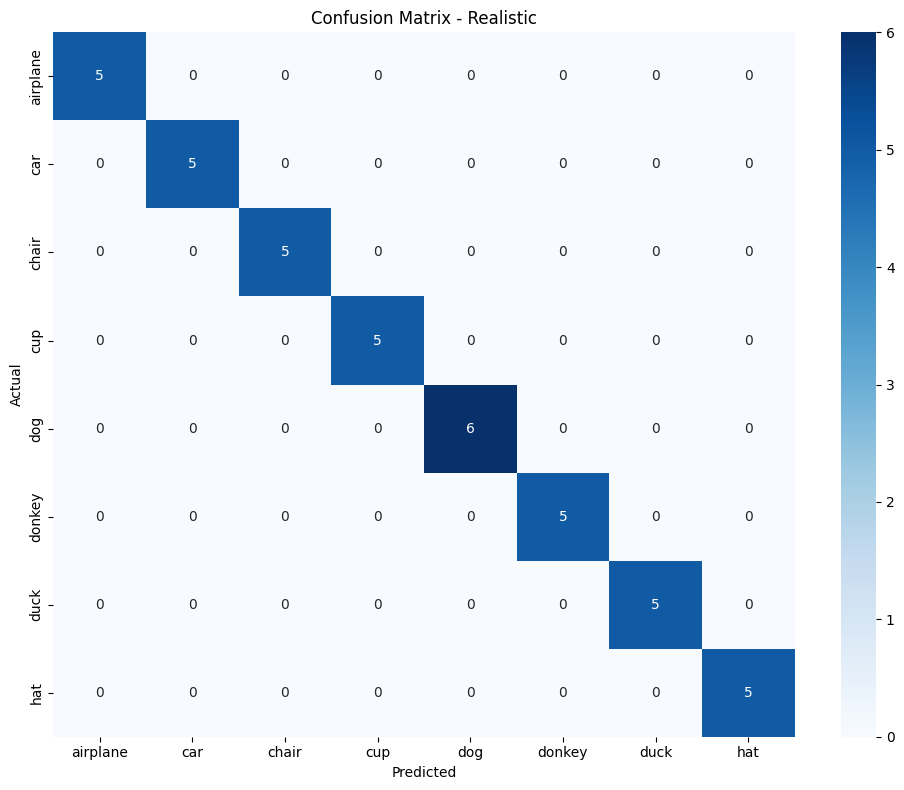


--- GEONS ---
Accuracy: 0.49
Confusion Matrix:
[[5 0 0 3 0 0 0 0]
 [0 0 7 0 0 0 0 1]
 [0 0 7 0 0 0 0 0]
 [0 0 0 8 0 0 0 0]
 [0 1 4 1 0 0 1 0]
 [0 0 0 7 0 0 0 0]
 [0 0 0 5 0 0 2 0]
 [0 0 0 0 0 0 0 7]]

Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      0.62      0.77         8
         car       0.00      0.00      0.00         8
       chair       0.39      1.00      0.56         7
         cup       0.33      1.00      0.50         8
         dog       0.00      0.00      0.00         7
      donkey       0.00      0.00      0.00         7
        duck       0.67      0.29      0.40         7
         hat       0.88      1.00      0.93         7

    accuracy                           0.49        59
   macro avg       0.41      0.49      0.40        59
weighted avg       0.41      0.49      0.40        59



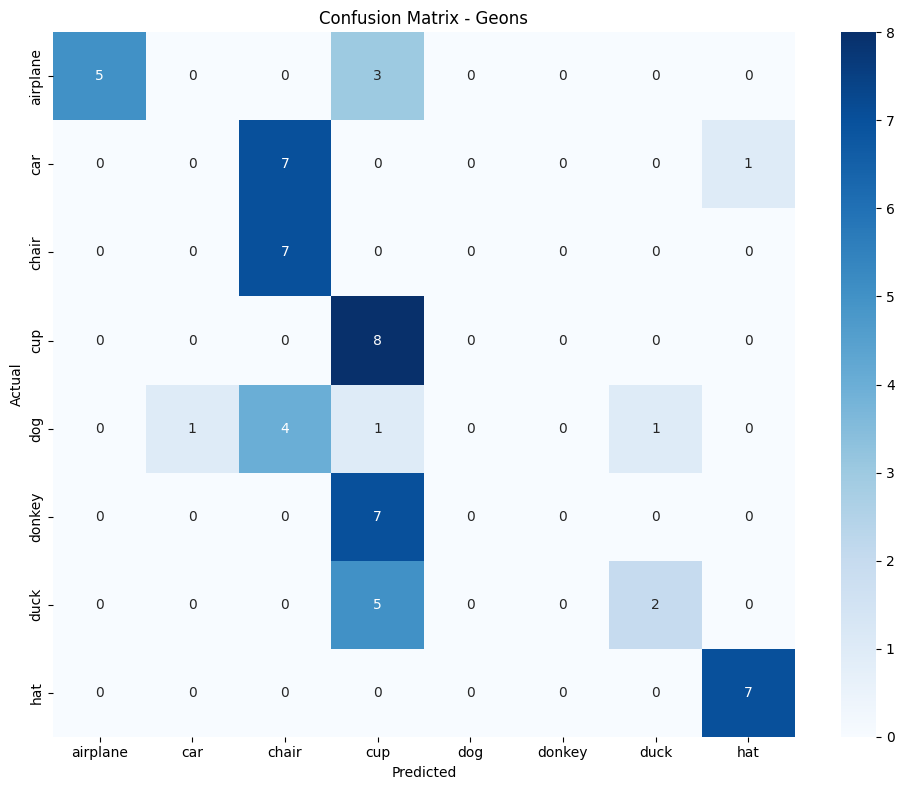


--- SILHOUETTES ---
Accuracy: 0.85
Confusion Matrix:
[[5 0 0 0 0 0 0 0]
 [0 4 0 0 1 0 0 0]
 [0 0 5 0 0 0 0 0]
 [0 0 0 3 0 0 0 3]
 [0 0 0 0 3 0 0 1]
 [0 0 0 0 1 4 0 0]
 [0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 5]]

Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00         5
         car       1.00      0.80      0.89         5
       chair       1.00      1.00      1.00         5
         cup       1.00      0.50      0.67         6
         dog       0.60      0.75      0.67         4
      donkey       1.00      0.80      0.89         5
        duck       1.00      1.00      1.00         5
         hat       0.56      1.00      0.71         5

    accuracy                           0.85        40
   macro avg       0.89      0.86      0.85        40
weighted avg       0.90      0.85      0.85        40



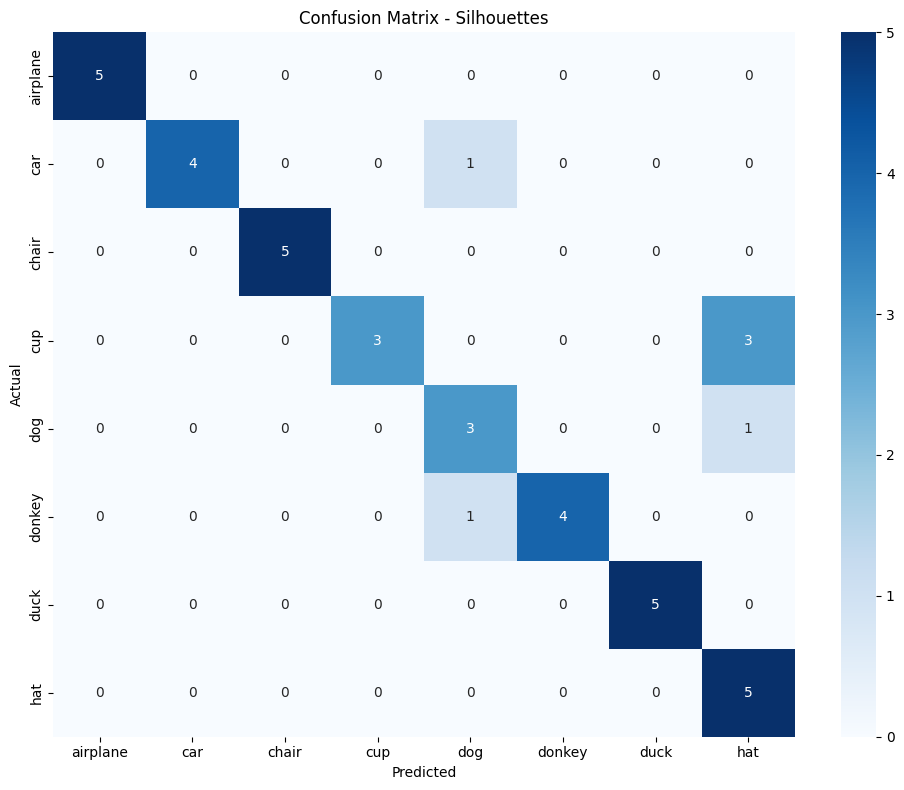


--- BLURRED ---
Accuracy: 0.71
Confusion Matrix:
[[5 0 0 0 0 0 0 1]
 [0 3 0 0 0 0 0 2]
 [0 0 6 0 0 0 0 0]
 [0 0 0 1 0 0 0 4]
 [0 0 1 0 3 0 0 1]
 [0 0 0 0 2 2 0 0]
 [0 0 0 0 0 0 5 1]
 [0 0 0 0 0 0 0 5]]

Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      0.83      0.91         6
         car       1.00      0.60      0.75         5
       chair       0.86      1.00      0.92         6
         cup       1.00      0.20      0.33         5
         dog       0.60      0.60      0.60         5
      donkey       1.00      0.50      0.67         4
        duck       1.00      0.83      0.91         6
         hat       0.36      1.00      0.53         5

    accuracy                           0.71        42
   macro avg       0.85      0.70      0.70        42
weighted avg       0.86      0.71      0.72        42



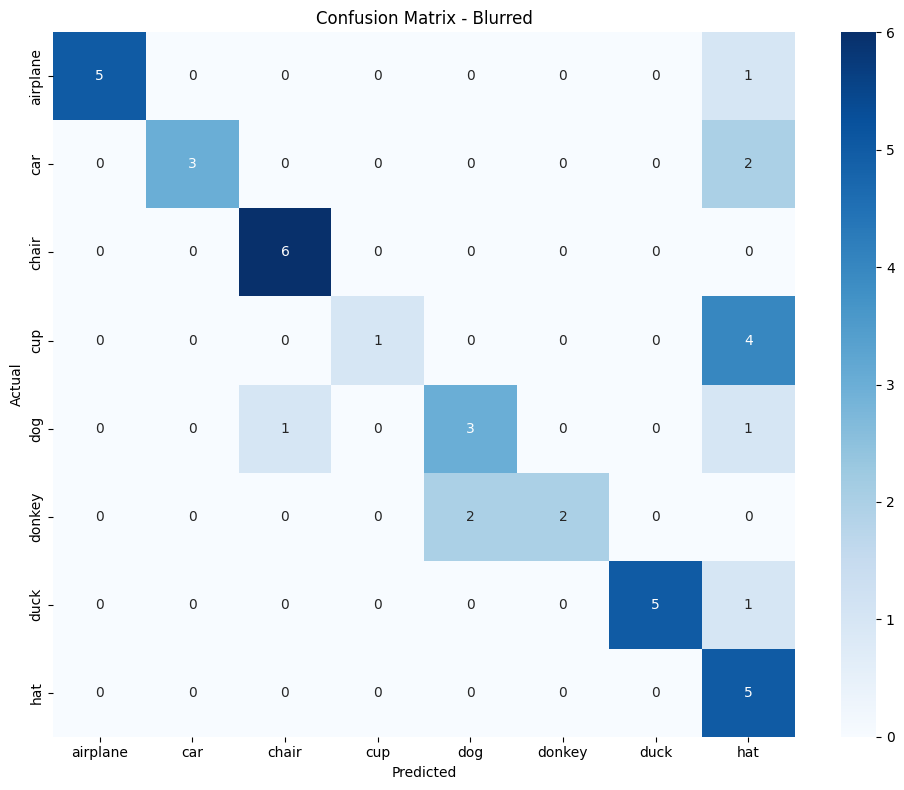


--- FEATURES ---
Accuracy: 0.66
Confusion Matrix:
[[3 2 0 0 0 0 0 1]
 [0 5 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0]
 [0 0 0 2 0 0 0 3]
 [0 0 0 0 5 0 0 0]
 [0 0 0 0 1 0 0 3]
 [0 0 0 0 0 0 2 4]
 [0 0 0 0 0 0 0 5]]

Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      0.50      0.67         6
         car       0.71      1.00      0.83         5
       chair       1.00      1.00      1.00         5
         cup       1.00      0.40      0.57         5
         dog       0.83      1.00      0.91         5
      donkey       0.00      0.00      0.00         4
        duck       1.00      0.33      0.50         6
         hat       0.31      1.00      0.48         5

    accuracy                           0.66        41
   macro avg       0.73      0.65      0.62        41
weighted avg       0.76      0.66      0.63        41



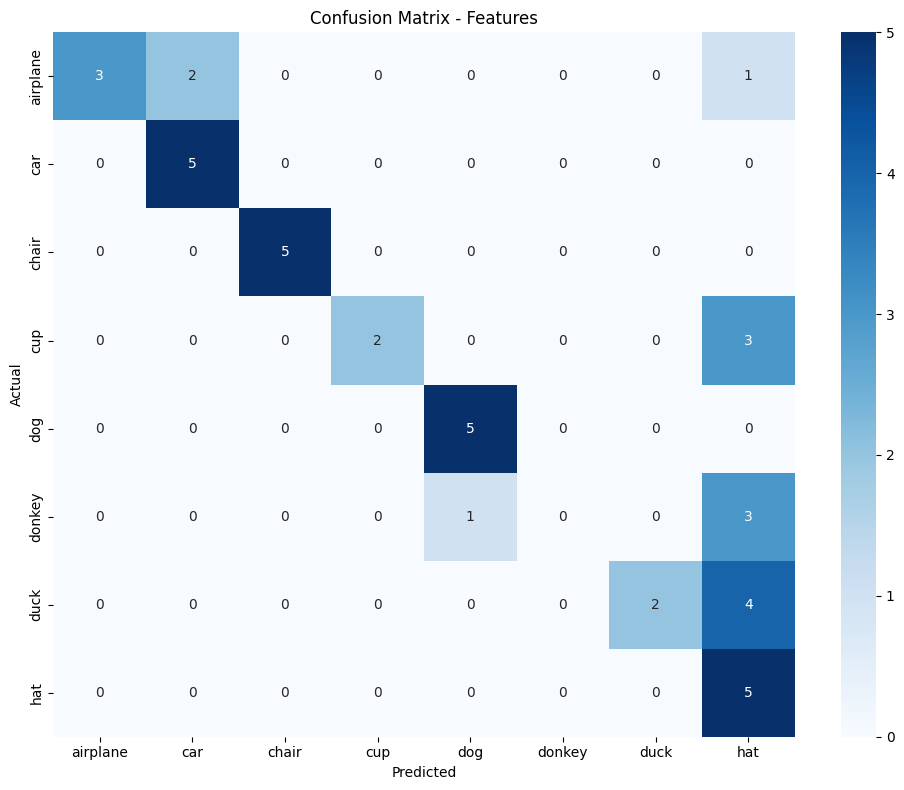

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define categories and conditions
categories = ["airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"]
conditions = ["realistic", "geons", "silhouettes", "blurred", "features"]

# Text processing
text_inputs = processor(
    text=[f"a photo of a {c}" for c in categories],
    return_tensors="pt",
    padding=True
).to(device)

def get_category(filename):
    filename_lower = filename.lower()
    for category in categories:
        if category.lower() in filename_lower:
            return category
    return None

def evaluate_condition(condition):
    y_true, y_pred = [], []
    condition_dir = os.path.join(data_root, condition)

    if not os.path.exists(condition_dir):
        print(f"Directory not found: {condition_dir}")
        return None, None, None, None

    for img_name in os.listdir(condition_dir):
        category = get_category(img_name)
        if category and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                image = Image.open(os.path.join(condition_dir, img_name)).convert("RGB")
                inputs = processor(images=image, return_tensors="pt").to(device)

                with torch.no_grad():
                    outputs = model(**inputs, **text_inputs)
                    probs = outputs.logits_per_image.softmax(dim=1)
                    pred_idx = probs.argmax().item()
                    true_idx = categories.index(category)

                y_true.append(true_idx)
                y_pred.append(pred_idx)
            except Exception as e:
                print(f"Skipped {img_name}: {str(e)}")
                continue

    if not y_true:
        return None, None, None, None

    cm = confusion_matrix(y_true, y_pred, labels=range(len(categories)))
    acc = accuracy_score(y_true, y_pred)
    return cm, acc, y_true, y_pred

# Evaluate all conditions and plot
results = {}
for condition in conditions:
    cm, acc, y_true, y_pred = evaluate_condition(condition)
    if cm is not None:
        results[condition] = {"accuracy": acc, "confusion_matrix": cm}
        print(f"\n--- {condition.upper()} ---")
        print(f"Accuracy: {acc:.2f}")
        print("Confusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=categories, zero_division=0))

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
        plt.title(f"Confusion Matrix - {condition.capitalize()}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()


**In which conditions is your models better/worse/similar to babies (Fig. 3A in this paper: https://osf.io/preprints/psyarxiv/83gae**

We compared our CLIP model’s classification accuracy against 2-year-old children's performance across five visual conditions, using Figure 3A of the Model-vs-Baby paper as a reference. The results show that CLIP consistently outperforms infants in nearly all tested conditions. For realistic and silhouette images, CLIP achieved 100% and 85% accuracy respectively, exceeding the average infant performance.

In blurred and features conditions, CLIP maintained good performance of 71% and 66% respectively, far above the infant baselines of ~52% and ~38%. However, in the geons condition, which removes surface features and highlights shape structure, CLIP’s accuracy dropped to 49%, aligning closely with infants' ~52%. This suggests that both the model and infants struggle with purely structural cues, though CLIP excels when low-level visual information is preserved.

**Question 3) From the output of the final layer of the vision encoder (before the projection layer into the shared embedding space) take embeddings for each image in the dataset. Apply t-SNE to those embeddings and plot them in a 2D space - plot little images of objects in the embedding space (something like Fig. 4 in this paper: https://osf.io/preprints/psyarxiv/83gaeLinks to an external site. but no need for color coding of bounding boxes)**

We extracted image embeddings from the final layer of CLIP's vision encoder, just before the projection layer into the shared embedding space.We obtained 768-dimensional feature vectors for each image across the five visual conditions: realistic, geons, silhouettes, blurred, and features.

We then applied t-SNE to reduce the dimensionality of these embeddings to 2D, and plotted them using image thumbnails (resized to 64×64 for clarity). Each point on the plot represents an image, visually clustered based on similarity in CLIP’s learned feature space.

These visualizations (taking reference of the Fig. 4 of the Model-vs-Baby paper) reveal how CLIP organizes objects:

* Images from the same category (e.g., ducks, cars, hats) tend to cluster together across conditions.

* In realistic and silhouette conditions, clusters are more compact and well-separated.

* In geons and features, representations are more dispersed, reflecting the model's reduced confidence and performance.

* The model appears to rely heavily on visual texture and shape continuity, which is disrupted in abstract representations.

In [ ]:
def extract_embeddings(condition):
    embeddings = []
    image_paths = []
    labels = []

    condition_dir = os.path.join(data_root, condition)
    if not os.path.exists(condition_dir):
        return None, None, None

    for img_name in os.listdir(condition_dir):
        category = get_category(img_name)
        if category and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                image_path = os.path.join(condition_dir, img_name)
                image = Image.open(image_path).convert("RGB")
                inputs = processor(images=image, return_tensors="pt").to(device)

                with torch.no_grad():
                    vision_outputs = model.vision_model(**inputs)
                    embedding = vision_outputs.last_hidden_state.mean(dim=1).cpu().numpy()

                embeddings.append(embedding)
                image_paths.append(image_path)
                labels.append(f"{condition}_{category}")
            except Exception as e:
                continue

    if not embeddings:
        return None, None, None

    return np.vstack(embeddings), image_paths, labels

 Visualizing condition: realistic


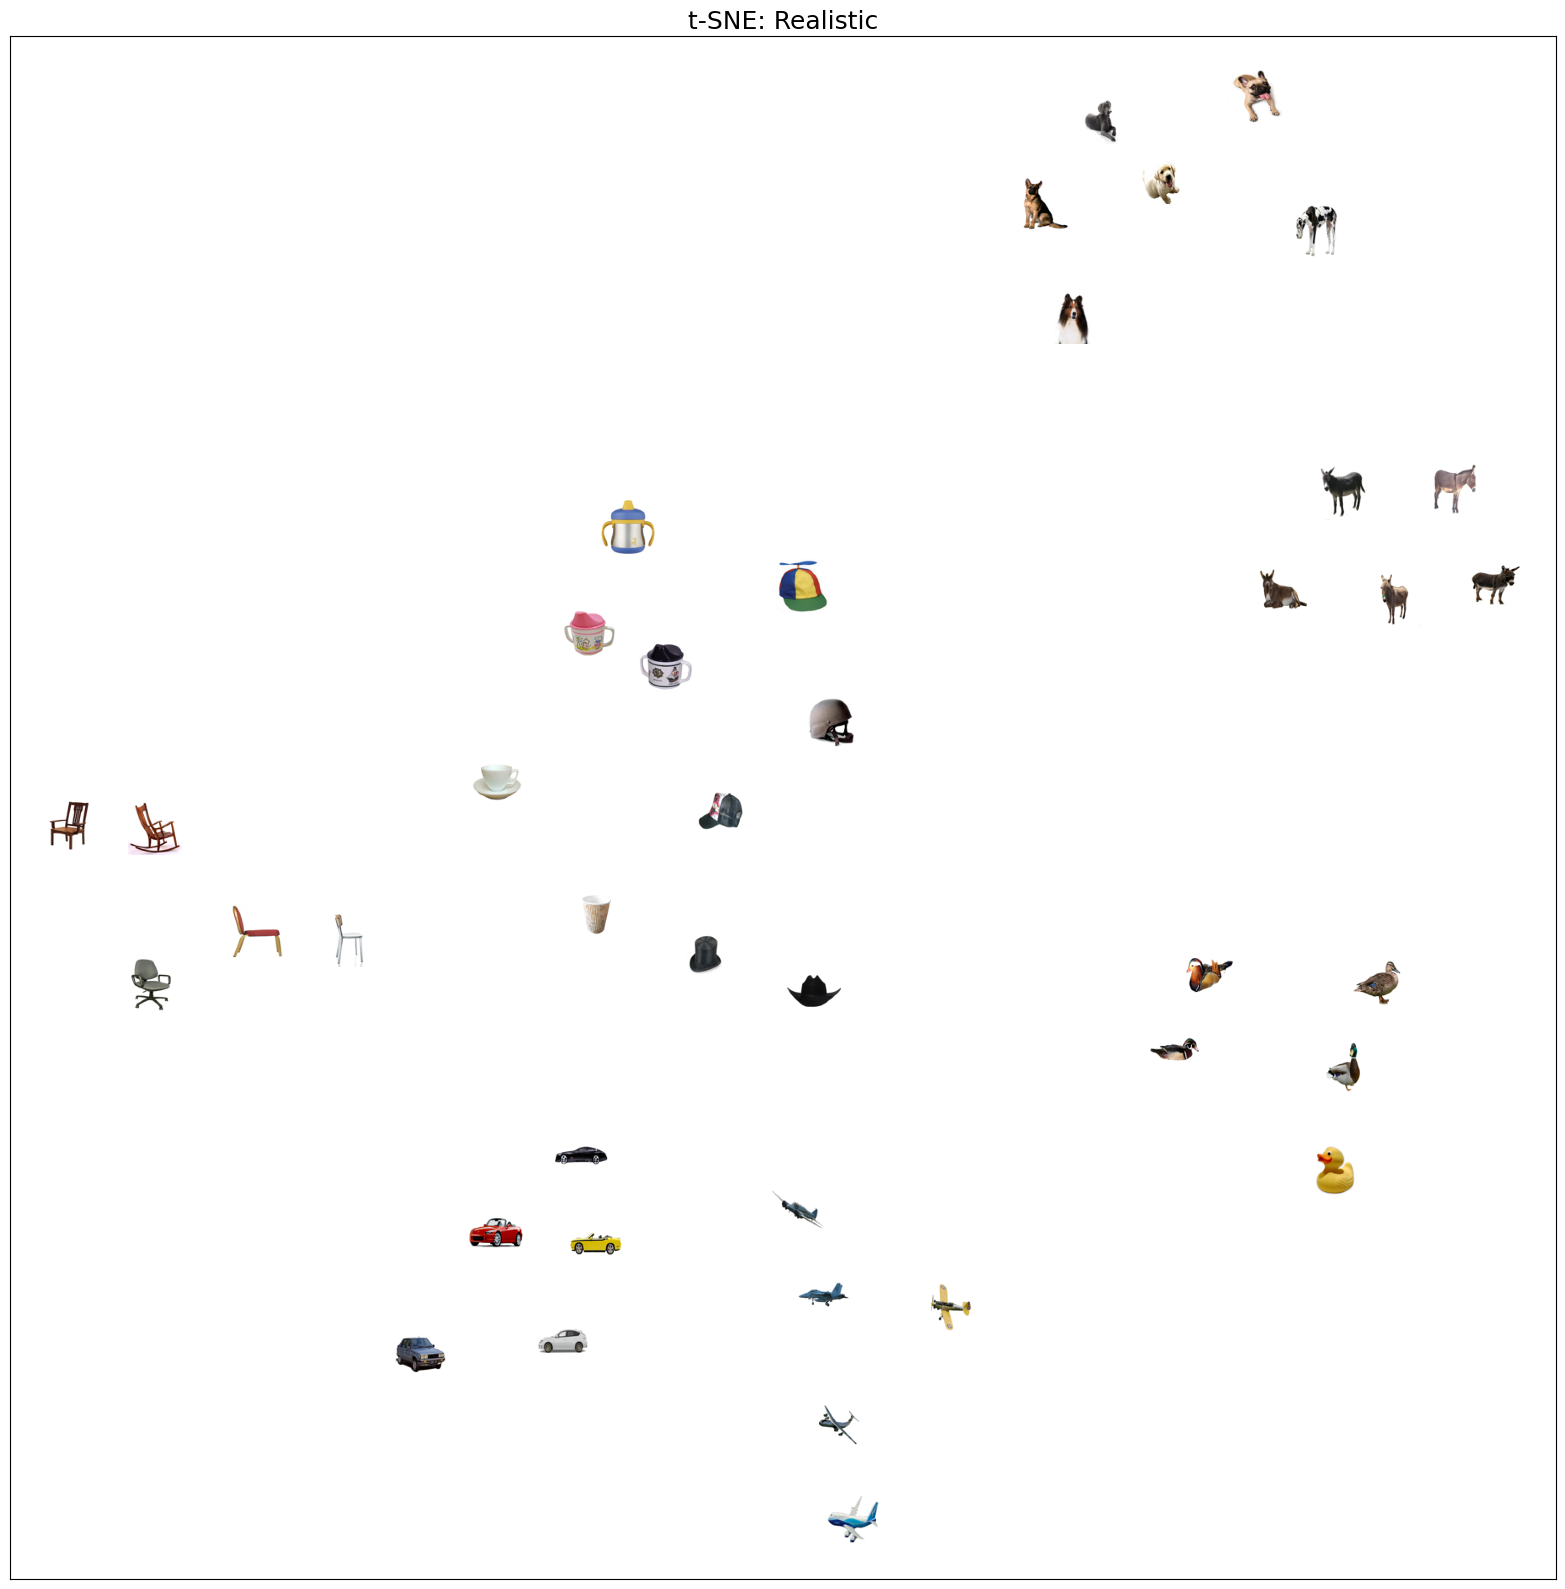

 Visualizing condition: geons


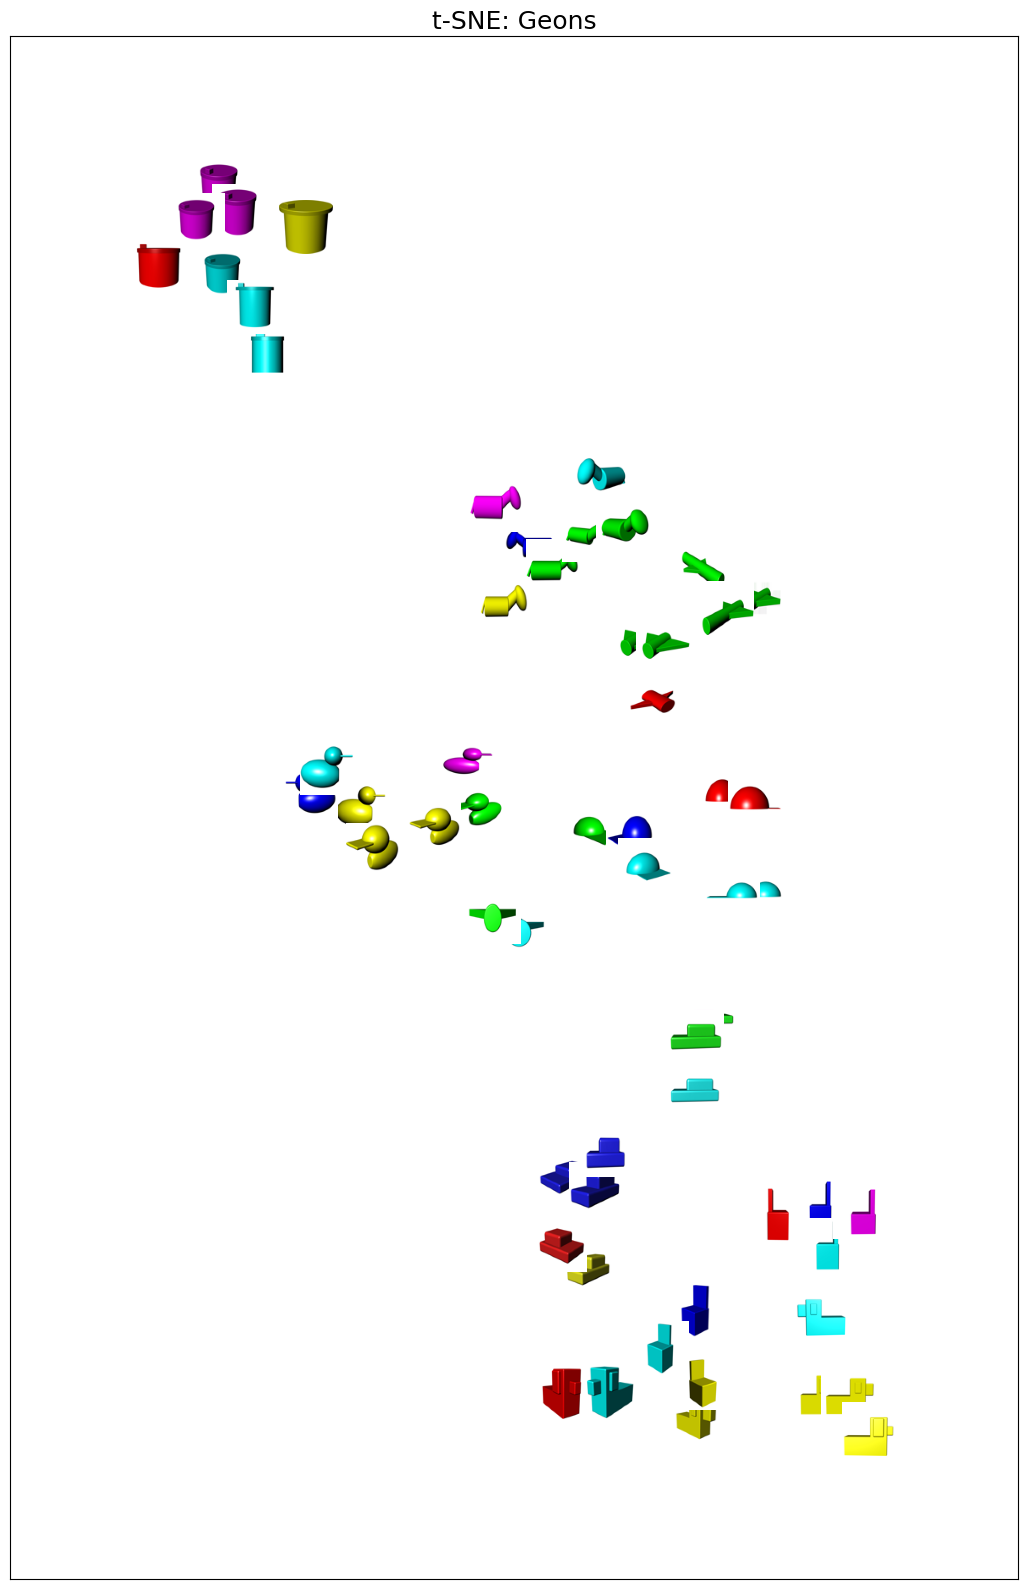

 Visualizing condition: silhouettes


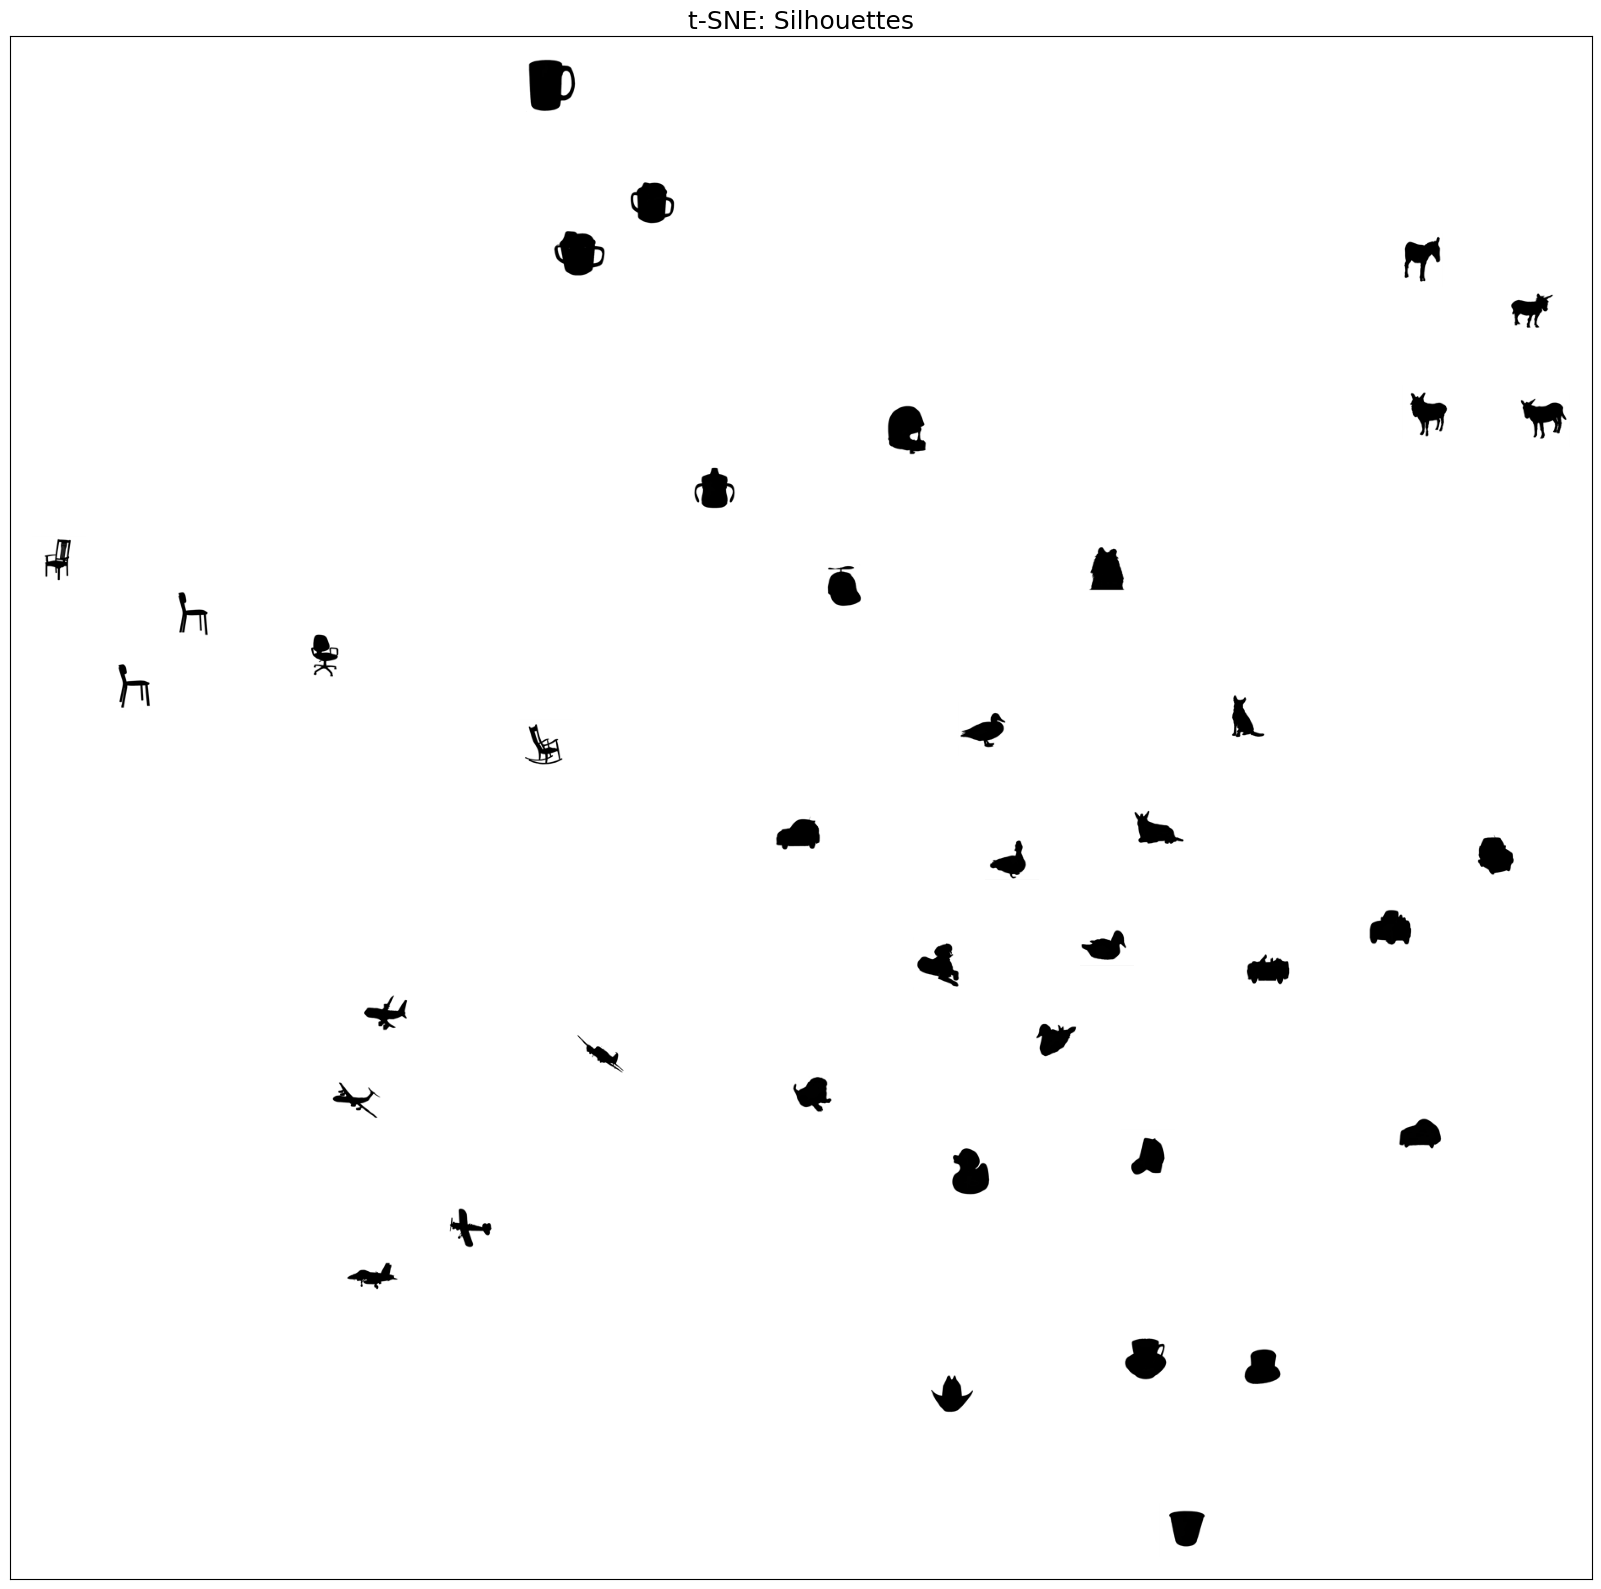

 Visualizing condition: blurred


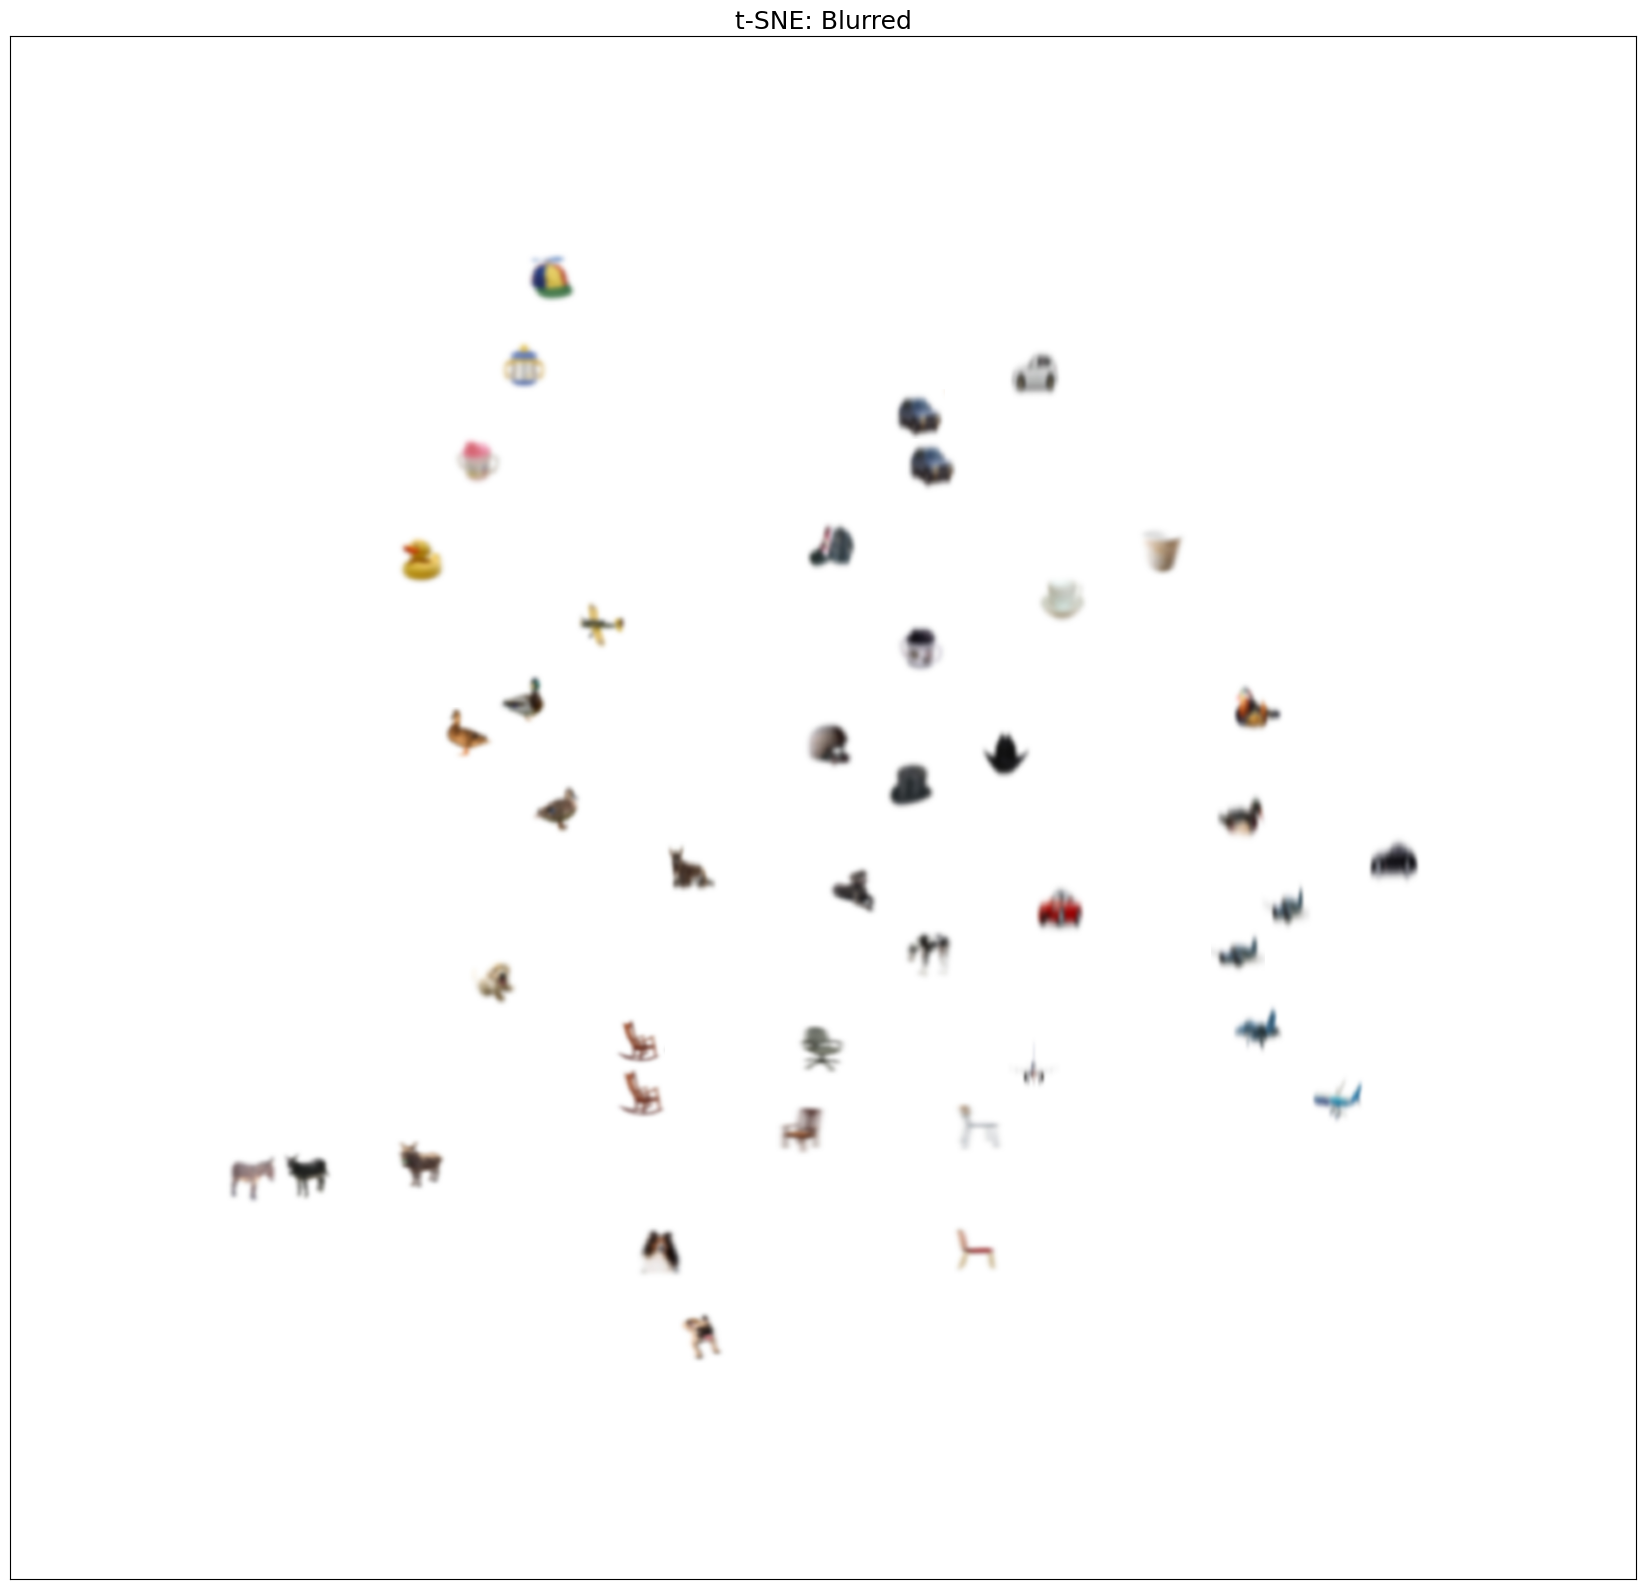

 Visualizing condition: features


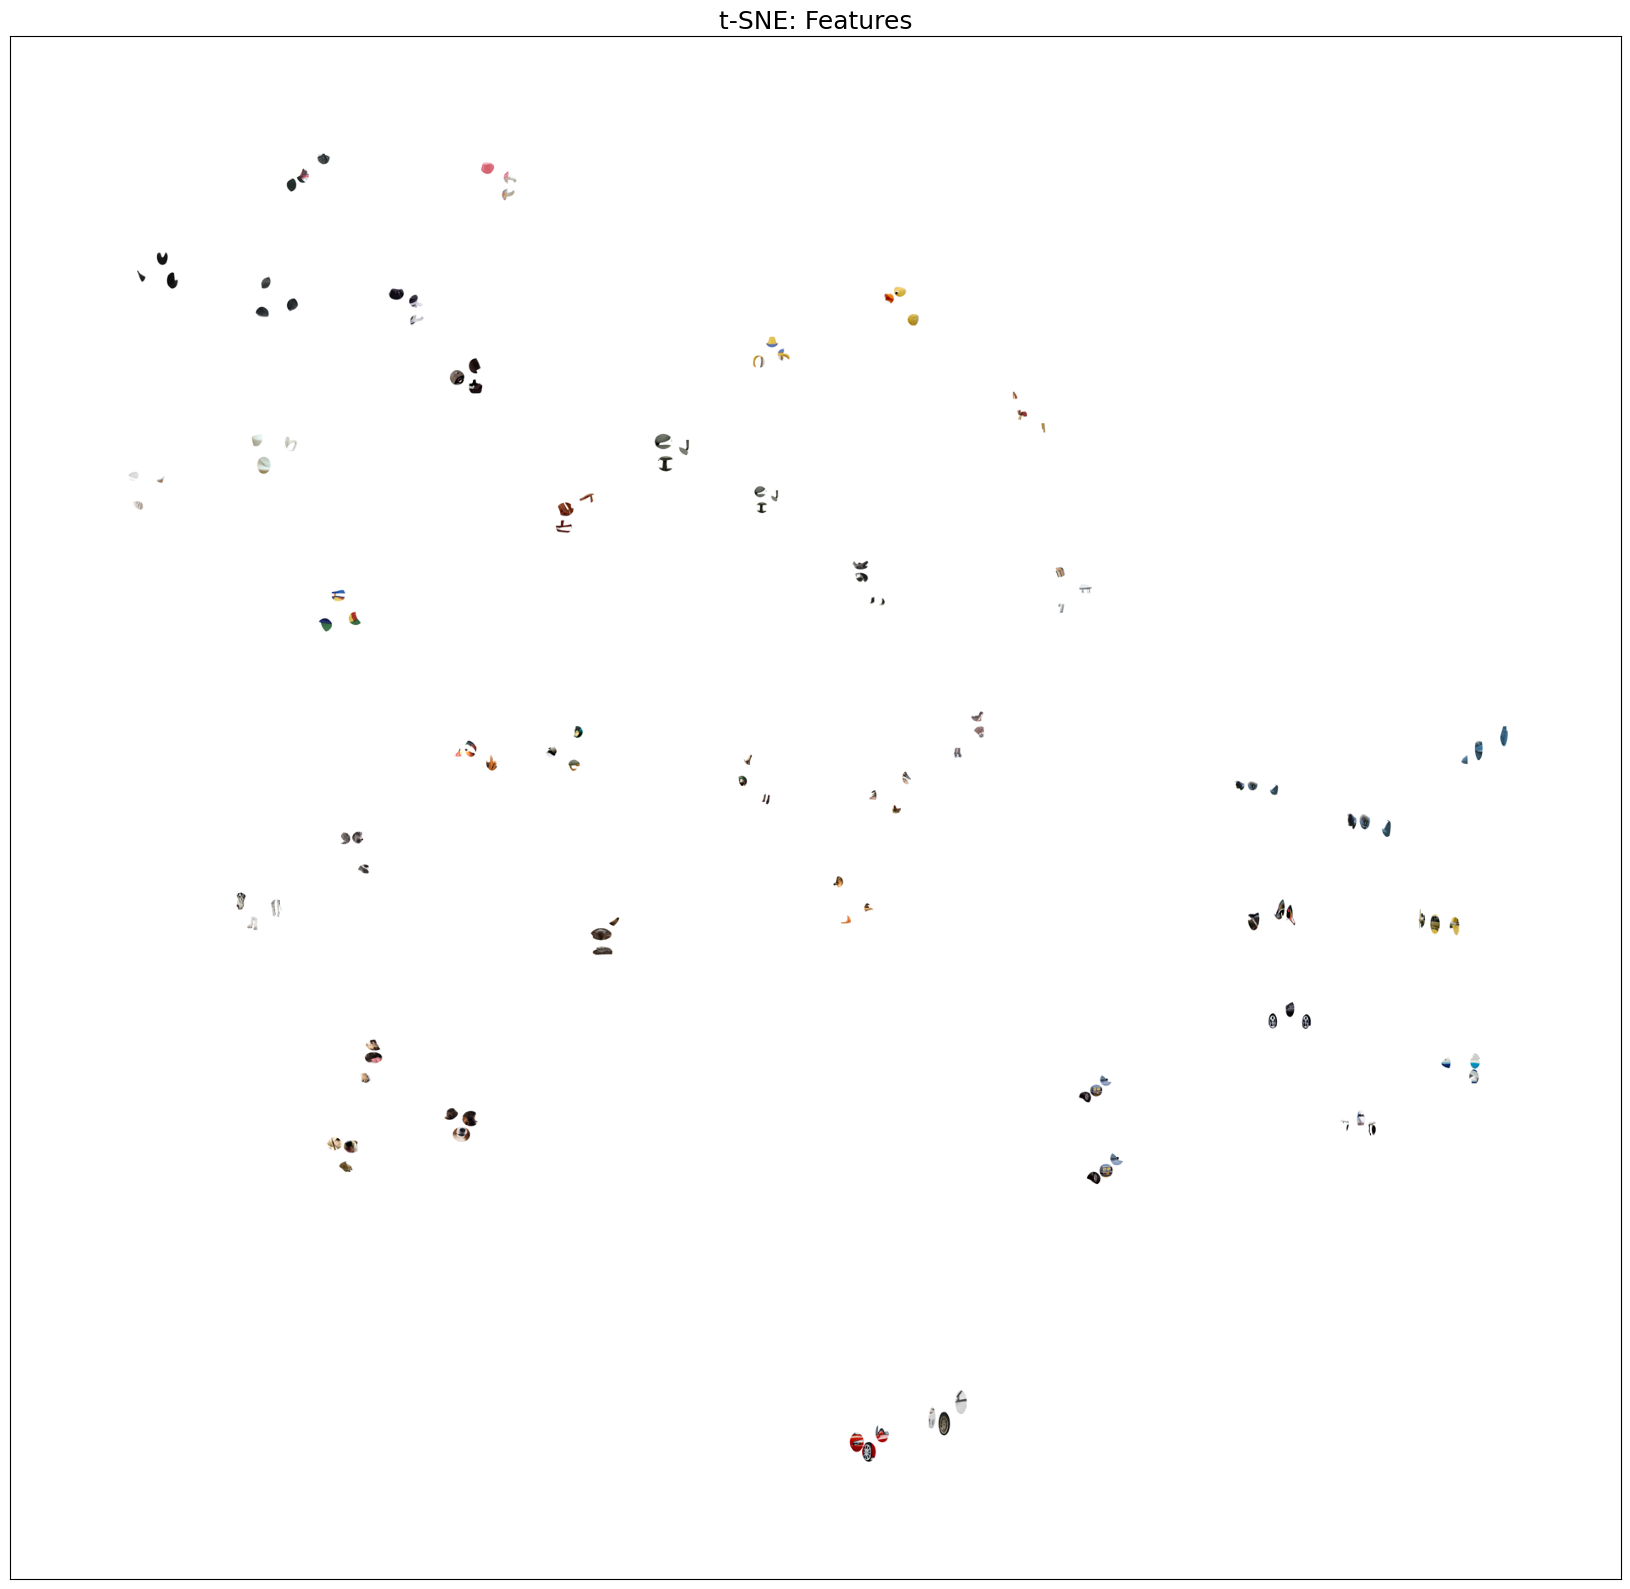

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from sklearn.manifold import TSNE

def plot_tsne_with_thumbnails(embeddings_2d, image_paths, labels, title="t-SNE of Image Representations"):
    fig, ax = plt.subplots(figsize=(20, 16))
    ax.set_title(title, fontsize=18)

    for (x, y), path in zip(embeddings_2d, image_paths):
        try:
            img = Image.open(path).resize((64, 64))  # Larger, clearer
            imagebox = OffsetImage(img, zoom=0.6)    # Increased zoom
            ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0.1)
            ax.add_artist(ab)
        except Exception as e:
            print(f"Failed to render {path}: {e}")
            continue

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(embeddings_2d[:, 0].min() - 5, embeddings_2d[:, 0].max() + 5)
    ax.set_ylim(embeddings_2d[:, 1].min() - 5, embeddings_2d[:, 1].max() + 5)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()



for condition in conditions:
    print(f" Visualizing condition: {condition}")
    embeddings, image_paths, labels = extract_embeddings(condition)

    if embeddings is not None:
        tsne = TSNE(n_components=2, perplexity=10, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)
        plot_tsne_with_thumbnails(embeddings_2d, image_paths, labels, title=f"t-SNE: {condition.capitalize()}")